## Import Library

In [33]:
#STANDARD BASIC LIBRARY
import pandas as pd
import numpy as np
import sys
import sklearn
import matplotlib.pyplot as plt

#DATA TRANSFORMATION
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#DATA NORMALIZATION
from sklearn import preprocessing

#FEATURE SELECTION
#ANNOVA f-TEST
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import StratifiedKFold

#MODEL BASED
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#RECURSIVE FEATURE ELIMINATION
from sklearn.feature_selection import RFE, RFECV

#LOCAL OUTLIER FACTOR
from sklearn.neighbors import LocalOutlierFactor

#CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

#METHOD EVALUATION
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from statistics import mean 
from sklearn.model_selection import ParameterGrid, StratifiedKFold

import time
from statistics import median

## Import dataset

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

#dataset features name
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty-level"]

#import dataset from drive
df = pd.read_csv("NSL-KDD/KDDTrain-.csv", header=None, names = col_names)
df_test = pd.read_csv("NSL-KDD/KDDTest-.csv", header=None, names = col_names)

#drop unused column
df.drop(columns="difficulty-level", inplace=True)
df_test.drop(columns="difficulty-level",inplace=True)

## Data transformation
### Checking categorical data

In [3]:
categorical_columns=['protocol_type', 'service', 'flag']
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
print("Categorical features in the dataset : ")
print(df_categorical_values.head())

Categorical features in the dataset : 
  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF


### create dummies column

In [5]:
#protocol
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]

#service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]

#flag
unique_flag = sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2 = [string3 + x for x in unique_flag]

#create dummies column
dumcols = unique_protocol2 + unique_service2 + unique_flag2
print("\nDummies column : ")
print(dumcols)

#change value into dummies column
unique_service_test = sorted(df_test.service.unique())
unique_service2_test = [string2 + x for x in unique_service_test]
testdumcols = unique_protocol2 + unique_service2_test + unique_flag2



Dummies column : 
['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service

### Encoding data using LabelEncoder

In [7]:
#Change value into number
#train
df_categorical_values_enc = df_categorical_values.apply(LabelEncoder().fit_transform)
#test
testdf_categorical_values_enc = testdf_categorical_values.apply(LabelEncoder().fit_transform)

### Change categorical value into numerical value

In [8]:
enc = OneHotEncoder()

#train set
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(), columns=dumcols)

#test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(), columns=testdumcols)

### check difference feature between train set and test set

In [9]:
trainservice=df['service'].tolist()
testservice=df_test['service'].tolist()
difference=list(set(trainservice)-set(testservice))
string = 'service_'
difference = [string + x for x in difference]
difference

['service_aol',
 'service_harvest',
 'service_red_i',
 'service_urh_i',
 'service_http_2784',
 'service_http_8001']

### delete difference features

In [10]:
for col in difference:
    testdf_cat_data[col] = 0

### Join prepared features with the dataset

In [11]:
#train data
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type',axis=1, inplace=True)
newdf.drop('service',axis=1, inplace=True)

#test data
newdf_test = df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type',axis=1, inplace=True)
newdf_test.drop('service',axis=1, inplace=True)

#shape of new dataset
print("\nNew shape of dataset : ")
print(newdf.shape)
print(newdf_test.shape)


New shape of dataset : 
(125973, 123)
(22544, 123)


## CREATE SUBSET DATASET
### DoS, Probe, R2L, U2R

In [13]:
#Change attack type label into 4 type (DoS, Probe, U2R, R2L)
#take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']

#change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

#put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

#Distribute label into several subset
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
#train
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];

#checking the data
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


### Split dataframes into X & Y

In [14]:
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## DATA NORMALIZATION
### Normalize the data, reduce scale different of each data

In [15]:
#Normalize data using StandardScaler
#Normalize data to reduce difference scale of each data
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

#Check the result of data normalization
print(X_DoS)
print(X_DoS)

[[-0.09931945 -0.02416949 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02523933 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02569207 -0.05230875 ... -0.01993587 -1.22542092
  -0.00420205]
 ...
 [-0.09931945 -0.01877379 -0.04470814 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02569207 -0.05230875 ... -0.01993587 -1.22542092
  -0.00420205]
 [-0.09931945 -0.02522383 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]]
[[-0.09931945 -0.02416949 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02523933 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02569207 -0.05230875 ... -0.01993587 -1.22542092
  -0.00420205]
 ...
 [-0.09931945 -0.01877379 -0.04470814 ... -0.01993587  0.81604613
  -0.00420205]
 [-0.09931945 -0.02569207 -0.05230875 ... -0.01993587 -1.22542092
  -0.00420205]
 [-0.09931945 -0.02522383 -0.05230875 ... -0.01993587  0.81604613
  -0.00420205]]


### PERFORMANCE EVALUATION BEFORE THE PROPOSED METHOD

### DoS

In [16]:
start1 = time.time()
clf_DoS = DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS)
Y_DoS_pred = clf_DoS.predict(X_DoS_test)
time1 = (time.time()-start1)

In [17]:
cm_dos_all = confusion_matrix(Y_DoS_test, Y_DoS_pred)
print(pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_dos_all = cm_dos_all[1][1]
FN_dos_all = cm_dos_all[1][0]
FP_dos_all = cm_dos_all[0][1]
TN_dos_all = cm_dos_all[0][0]
acc_dos_all = (TP_dos_all+TN_dos_all)/(TP_dos_all+TN_dos_all+FP_dos_all+FN_dos_all)
sen_dos_all = TP_dos_all/(TP_dos_all+FN_dos_all)
spe_dos_all = TN_dos_all/(TN_dos_all+FP_dos_all)
fal_dos_all = FP_dos_all/(FP_dos_all+TN_dos_all)
print("Accuracy DoS all features : ", acc_dos_all)
print("Sensitivity DoS all features : ", sen_dos_all)
print("Specificity DoS all features :", spe_dos_all)
print("False Alarm rate DoS all features : ", fal_dos_all)
print("Computation time DoS all features : ", time1)

Predicted activity     0     1
Actual activity               
0                   9499   212
1                   2830  4630
Accuracy DoS all features :  0.822840836293751
Sensitivity DoS all features :  0.6206434316353887
Specificity DoS all features : 0.9781690866028215
False Alarm rate DoS all features :  0.021830913397178457
Computation time DoS all features :  2.198688268661499


### Probe

In [18]:
start2 = time.time()
clf_Probe = DecisionTreeClassifier(random_state=0)
clf_Probe.fit(X_Probe, Y_Probe)
Y_Probe_pred = clf_Probe.predict(X_Probe_test)
time2 = (time.time()-start2)

In [19]:
cm_Probe_all = confusion_matrix(Y_Probe_test, Y_Probe_pred)
print(pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_Probe_all = cm_Probe_all[1][1]
FN_Probe_all = cm_Probe_all[1][0]
FP_Probe_all = cm_Probe_all[0][1]
TN_Probe_all = cm_Probe_all[0][0]
acc_Probe_all = (TP_Probe_all+TN_Probe_all)/(TP_Probe_all+TN_Probe_all+FP_Probe_all+FN_Probe_all)
sen_Probe_all = TP_Probe_all/(TP_Probe_all+FN_Probe_all)
spe_Probe_all = TN_Probe_all/(TN_Probe_all+FP_Probe_all)
fal_Probe_all = FP_Probe_all/(FP_Probe_all+TN_Probe_all)
print("Accuracy Probe all features : ", acc_Probe_all)
print("Sensitivity Probe all features : ", sen_Probe_all)
print("Specificity Probe all features :", spe_Probe_all)
print("False Alarm rate Probe all features : ", fal_Probe_all)
print("Computation time Probe all features : ", time2)

Predicted activity     0     2
Actual activity               
0                   2337  7374
2                    212  2209
Accuracy Probe all features :  0.3747115067589845
Sensitivity Probe all features :  0.9124328789756299
Specificity Probe all features : 0.24065492740191535
False Alarm rate Probe all features :  0.7593450725980846
Computation time Probe all features :  1.5099284648895264


### R2L

In [20]:
start3 = time.time()
clf_R2L = DecisionTreeClassifier(random_state=0)
clf_R2L.fit(X_R2L, Y_R2L)
Y_R2L_pred = clf_R2L.predict(X_R2L_test)
time3 = (time.time()-start3)

In [21]:
cm_R2L_all = confusion_matrix(Y_R2L_test, Y_R2L_pred)
print(pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_R2L_all = cm_R2L_all[1][1]
FN_R2L_all = cm_R2L_all[1][0]
FP_R2L_all = cm_R2L_all[0][1]
TN_R2L_all = cm_R2L_all[0][0]
acc_R2L_all = (TP_R2L_all+TN_R2L_all)/(TP_R2L_all+TN_R2L_all+FP_R2L_all+FN_R2L_all)
sen_R2L_all = TP_R2L_all/(TP_R2L_all+FN_R2L_all)
spe_R2L_all = TN_R2L_all/(TN_R2L_all+FP_R2L_all)
fal_R2L_all = FP_R2L_all/(FP_R2L_all+TN_R2L_all)
print("Accuracy R2L all features : ", acc_R2L_all)
print("Sensitivity R2L all features : ", sen_R2L_all)
print("Specificity R2L all features :", spe_R2L_all)
print("False Alarm rate R2L all features : ", fal_R2L_all)
print("Computation time R2L all features : ", time3)

Predicted activity     0    3
Actual activity              
0                   9707    4
3                   2573  312
Accuracy R2L all features :  0.7954112416640203
Sensitivity R2L all features :  0.10814558058925476
Specificity R2L all features : 0.9995880959736382
False Alarm rate R2L all features :  0.0004119040263618577
Computation time R2L all features :  0.9844636917114258


### U2R

In [22]:
start4 = time.time()
clf_U2R = DecisionTreeClassifier(random_state=0)
clf_U2R.fit(X_U2R, Y_U2R)
Y_U2R_pred = clf_U2R.predict(X_U2R_test)
time4 = (time.time()-start4)

In [23]:
cm_U2R_all = confusion_matrix(Y_U2R_test, Y_U2R_pred)
print(pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_U2R_all = cm_U2R_all[1][1]
FN_U2R_all = cm_U2R_all[1][0]
FP_U2R_all = cm_U2R_all[0][1]
TN_U2R_all = cm_U2R_all[0][0]
acc_U2R_all = (TP_U2R_all+TN_U2R_all)/(TP_U2R_all+TN_U2R_all+FP_U2R_all+FN_U2R_all)
sen_U2R_all = TP_U2R_all/(TP_U2R_all+FN_U2R_all)
spe_U2R_all = TN_U2R_all/(TN_U2R_all+FP_U2R_all)
fal_U2R_all = FP_U2R_all/(FP_U2R_all+TN_U2R_all)
print("Accuracy U2R all features : ", acc_U2R_all)
print("Sensitivity U2R all features : ", sen_U2R_all)
print("Specificity U2R all features :", spe_U2R_all)
print("False Alarm rate U2R all features : ", fal_U2R_all)
print("Computation time U2R all features : ", time4)

Predicted activity     0  4
Actual activity            
0                   9703  8
4                     60  7
Accuracy U2R all features :  0.9930456125997137
Sensitivity U2R all features :  0.1044776119402985
Specificity U2R all features : 0.9991761919472762
False Alarm rate U2R all features :  0.0008238080527237154
Computation time U2R all features :  0.662438154220581


## PROPOSED METHOD
## DoS
### Filter method - Calculate features importance

Feature importance of DoS : 
0.7477422769453029
0.08553569080080681
0.07779626099918012
0.029020098931090796
0.02800705404339967
0.02239883985079247
0.0030026152799276264
0.002134426001107195
0.0010236583065813608
0.0007394068520952914
0.000660268301327926
0.00042939346755217853
0.00040254058884719437
0.0002777885194002598
0.00018304563569080526
0.00012191196829023436
0.00010984918391706662
8.138107392178597e-05
7.590192736652465e-05
4.695024702563871e-05
4.6723689269332595e-05
3.658168833467759e-05
3.581247125869956e-05
3.380897636310793e-05
1.8530348046183034e-05
1.8498177303047283e-05
1.669011950352225e-05
3.995606297458221e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

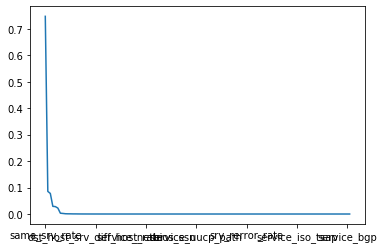

In [24]:
n = 122
model_DoS = DecisionTreeClassifier(random_state=0)
#DoS
model_DoS.fit(X_DoS,Y_DoS)
feat_importances = pd.Series(model_DoS.feature_importances_, index=colNames)
feat_importances.nlargest(n).plot(kind='line')
print("Feature importance of DoS : ")
for x in feat_importances.nlargest(n):
    print(x)
plt.show()

In [25]:
pd.set_option('display.max_rows', None)
print(feat_importances)

duration                       0.000000
src_bytes                      0.077796
dst_bytes                      0.001024
land                           0.000037
wrong_fragment                 0.028007
urgent                         0.000000
hot                            0.000000
num_failed_logins              0.000000
logged_in                      0.000183
num_compromised                0.022399
root_shell                     0.000000
su_attempted                   0.000000
num_root                       0.000000
num_file_creations             0.000000
num_shells                     0.000000
num_access_files               0.000000
num_outbound_cmds              0.000000
is_host_login                  0.000000
is_guest_login                 0.000000
count                          0.000034
srv_count                      0.000004
serror_rate                    0.000000
srv_serror_rate                0.000000
rerror_rate                    0.000000
srv_rerror_rate                0.000000


### Using mean threshold to separate importances features with unused features

In [28]:
from statistics import median

feat_dos_value = []
dosIm = []
#create list of importance value
for i in range(0,122,1):
  feat_dos_value.append(feat_importances[i])

#delete non zero
#create threshold from median value 
dos_nonzero = [x for x in feat_dos_value if x != 0]
thres = median(dos_nonzero)

#remove feature below threhsold
for j in range(0,122,1):
  if(feat_dos_value[j] > thres): 
    dosIm.append(j)

#calculate how many features
n_dos_feat = len(dosIm)

### Wrapper method - RFE

In [29]:
param_grid = {'n_features':[i for i in range(1,n_dos_feat+1,1)]}

#DoS
cv_res_dos=[]
for params in ParameterGrid(param_grid):
    cv_folds = []
        
    dcs = DecisionTreeClassifier(random_state=0)
    rfe_grid = RFE(estimator=dcs, n_features_to_select=params['n_features'], step=1)
    rfe_grid.fit(X_DoS, Y_DoS)
        
    cv_folds.append(rfe_grid.score(X_DoS_test, Y_DoS_test))
    
    cv_res_dos.append(np.mean(cv_folds))
    print("combination of parameters: " + str(params) + " ended ")


combination of parameters: {'n_features': 1} ended 
combination of parameters: {'n_features': 2} ended 
combination of parameters: {'n_features': 3} ended 
combination of parameters: {'n_features': 4} ended 
combination of parameters: {'n_features': 5} ended 
combination of parameters: {'n_features': 6} ended 
combination of parameters: {'n_features': 7} ended 
combination of parameters: {'n_features': 8} ended 
combination of parameters: {'n_features': 9} ended 
combination of parameters: {'n_features': 10} ended 
combination of parameters: {'n_features': 11} ended 
combination of parameters: {'n_features': 12} ended 
combination of parameters: {'n_features': 13} ended 
combination of parameters: {'n_features': 14} ended 


### find best subset of features combination

In [30]:
max_rfe_dos = cv_res_dos[0]
for f in range(0,len(cv_res_dos),1):
    if cv_res_dos[f] > max_rfe_dos:
      max_rfe_dos = cv_res_dos[f]
      ind_max_dos = f+1
print("Best score RFE : ",max_rfe_dos)
print("Number of selected features : ", ind_max_dos)

Best score RFE :  0.8898142216527867
Number of selected features :  8


In [31]:
for x in cv_res_dos:
    print(x)

0.43439520121134473
0.39875371265505793
0.39875371265505793
0.8548715858132898
0.8544056840020966
0.8724011414594374
0.874031797798614
0.8898142216527867
0.849164288626172
0.8425251878166676
0.8401956787607012
0.8269757148680915
0.8407780560246928
0.8318676838856212


In [32]:
#RFE DOS
est = DecisionTreeClassifier(random_state=0)
rfe_DoS = RFE(estimator=est, n_features_to_select=ind_max_dos, step=1)
#rfe_DoS = RFE(estimator=est, n_features_to_select=8, step=1)
rfe_DoS.fit(X_DoS, Y_DoS)
X_DoS_rfe = rfe_DoS.transform(X_DoS)
true=rfe_DoS.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

print('Features selected for DoS:',rfecolname_DoS)
print()
print(X_DoS_rfe.shape)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i']

(113270, 8)


## Evaluate the method
### Feat + RFE

In [34]:
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
start5 = time.time()
clf_DoS_rfe = DecisionTreeClassifier(random_state=0)
clf_DoS_rfe.fit(X_DoS_rfe, Y_DoS)
Y_DoS_pred2 = clf_DoS_rfe.predict(X_DoS_test2)
time5 = (time.time()-start5)

In [35]:
cm_dos_rfe = confusion_matrix(Y_DoS_test, Y_DoS_pred2)
print(pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_dos_rfe = cm_dos_rfe[1][1]
FN_dos_rfe = cm_dos_rfe[1][0]
FP_dos_rfe = cm_dos_rfe[0][1]
TN_dos_rfe = cm_dos_rfe[0][0]
acc_dos_rfe = (TP_dos_rfe+TN_dos_rfe)/(TP_dos_rfe+TN_dos_rfe+FP_dos_rfe+FN_dos_rfe)
sen_dos_rfe = TP_dos_rfe/(TP_dos_rfe+FN_dos_rfe)
spe_dos_rfe = TN_dos_rfe/(TN_dos_rfe+FP_dos_rfe)
fal_dos_rfe = FP_dos_rfe/(FP_dos_rfe+TN_dos_rfe)
print("Accuracy DoS all features : ", acc_dos_rfe)
print("Sensitivity DoS all features : ", sen_dos_rfe)
print("Specificity DoS all features :", spe_dos_rfe)
print("False Alarm rate DoS all features : ", fal_dos_rfe)
print("Computation time DoS all features : ", time5)

Predicted activity     0     1
Actual activity               
0                   9448   263
1                   1629  5831
Accuracy DoS all features :  0.8898142216527867
Sensitivity DoS all features :  0.7816353887399464
Specificity DoS all features : 0.9729173102667078
False Alarm rate DoS all features :  0.027082689733292142
Computation time DoS all features :  0.2005314826965332


### With Cross-validation

In [37]:
rfe_pred_DoS = cross_val_predict(clf_DoS_rfe, X_DoS_test2, Y_DoS_test, cv=10)
pd.crosstab(Y_DoS_test, rfe_pred_DoS, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9659,52
1,30,7430


## Data reduction
## Local Outlier Factor

In [38]:
print("Dataset shapes before : ")
print(X_DoS_rfe.shape)
print(X_DoS_test2.shape)

Dataset shapes before : 
(113270, 8)
(17171, 8)


### Calculate local outlier factor 

In [39]:
model_dos_lof = LocalOutlierFactor(n_neighbors = 300, contamination='auto')
model_dos_lof.fit_predict(X_DoS_rfe)
lof_dos_score = model_dos_lof.negative_outlier_factor_

In [40]:
print(max(lof_dos_score))
print(min(lof_dos_score))

-0.9399887517314842
-30309265977.535065


In [41]:
dos_mean = np.mean(lof_dos_score)
dos_std = np.std(lof_dos_score)
print('mean of the dataset is', dos_mean) 
print('std. deviation is', dos_std) 

mean of the dataset is -26261534.632225785
std. deviation is 545693028.795136


In [42]:
outlier_zscore = []
for i in lof_dos_score:
    z_score = (i-dos_mean)/dos_std
    outlier_zscore.append(z_score)

In [43]:
outlier = []
thres = 2
indexdos = []
for x in range(0,len(X_DoS_rfe),1):
    if abs(outlier_zscore[x]) > thres:
        outlier.append(outlier_zscore[x])
    elif abs(outlier_zscore[x]) < thres:
        #index non outlier data 
        indexdos.append(x)

In [44]:
print(len(outlier))
print(len(indexdos))

272
112998


In [45]:
X_DoS_lof = X_DoS_rfe[indexdos]
Y_DoS_lof = Y_DoS.iloc[indexdos]
print(X_DoS_lof.shape)
print(Y_DoS_lof.shape)

(112998, 8)
(112998,)


In [46]:
print(X_DoS_rfe.shape)
print(X_DoS_test2.shape)
print(Y_DoS.shape)
print(Y_DoS_test.shape)

(113270, 8)
(17171, 8)
(113270,)
(17171,)


### EVALUATE THE DATA REDUCTION METHOD

In [47]:
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
start9 = time.time()
clf_DoS_lof = DecisionTreeClassifier(random_state=0)
clf_DoS_lof.fit(X_DoS_lof, Y_DoS_lof)
Y_DoS_pred_lof = clf_DoS_lof.predict(X_DoS_test2)
time9 = (time.time()-start9)

In [48]:
cm_dos_lof = confusion_matrix(Y_DoS_test, Y_DoS_pred_lof)
print(pd.crosstab(Y_DoS_test, Y_DoS_pred_lof, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_dos_lof = cm_dos_lof[1][1]
FN_dos_lof = cm_dos_lof[1][0]
FP_dos_lof = cm_dos_lof[0][1]
TN_dos_lof = cm_dos_lof[0][0]
acc_dos_lof = (TP_dos_lof+TN_dos_lof)/(TP_dos_lof+TN_dos_lof+FP_dos_lof+FN_dos_lof)
sen_dos_lof = TP_dos_lof/(TP_dos_lof+FN_dos_lof)
spe_dos_lof = TN_dos_lof/(TN_dos_lof+FP_dos_lof)
fal_dos_lof = FP_dos_lof/(FP_dos_lof+TN_dos_lof)
print("Accuracy DoS all features : ", acc_dos_lof)
print("Sensitivity DoS all features : ", sen_dos_lof)
print("Specificity DoS all features :", spe_dos_lof)
print("False Alarm rate DoS all features : ", fal_dos_lof)
print("Computation time DoS all features : ", time9)

Predicted activity     0     1
Actual activity               
0                   9448   263
1                   1629  5831
Accuracy DoS all features :  0.8898142216527867
Sensitivity DoS all features :  0.7816353887399464
Specificity DoS all features : 0.9729173102667078
False Alarm rate DoS all features :  0.027082689733292142
Computation time DoS all features :  0.30999755859375


In [49]:
accuracy = cross_val_score(clf_DoS_lof, X_DoS_lof, Y_DoS_lof, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99942 (+/- 0.00050)


In [50]:
lof_pred = cross_val_predict(clf_DoS_lof, X_DoS_lof, Y_DoS_lof, cv=10)
pd.crosstab(Y_DoS_lof, lof_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,67234,32
1,33,45699


### Do the same thing to the Probe, R2L & U2R class

### Probe

### Feature Importance

Feature importance of Probe : 
0.6611695756712296
0.18561718339212188
0.055357301851843004
0.03454704312017217
0.011262664168660464
0.009421680496445027
0.006039939215410177
0.005483150302679054
0.004919037118234732
0.00462331004263008
0.004494778931705271
0.003251748932591445
0.002390184890381167
0.0015289038757274214
0.0014676338454950627
0.0010573654313096167
0.0009603547883802935
0.0009411196164049474
0.0007838750528640855
0.000660189182167035
0.0006370005676119486
0.0006084199507333648
0.0005027877007031599
0.0002987619093207106
0.0002883162715917101
0.00025155805466714227
0.00019854403160987036
0.0001770474738487625
0.00017480751120725046
0.00017253795901097567
0.00010061364953086534
0.00010041253403202886
9.971247828589506e-05
9.937312829113154e-05
9.900708048053892e-05
9.851049383008702e-05
3.3549047585467495e-05
3.34790007741732e-05
3.258379773381093e-05
9.967874349691136e-06
4.499555080217579e-06
1.4700032685161526e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

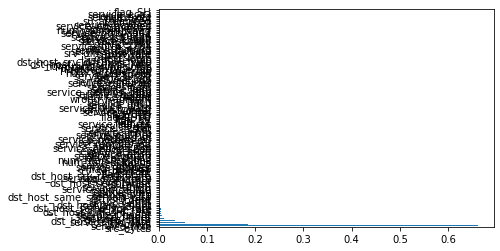

In [51]:
model_Probe = DecisionTreeClassifier(random_state=0)
model_Probe.fit(X_Probe,Y_Probe)
feat_importances_Probe = pd.Series(model_Probe.feature_importances_, index=colNames)
feat_importances_Probe.nlargest(n).plot(kind='barh')
print("Feature importance of Probe : ")
for x in feat_importances_Probe.nlargest(n):
    print(x)
plt.show()

In [52]:
feat_importances_Probe

duration                       0.000288
src_bytes                      0.661170
dst_bytes                      0.055357
land                           0.000000
wrong_fragment                 0.000000
urgent                         0.000000
hot                            0.000000
num_failed_logins              0.000033
logged_in                      0.000000
num_compromised                0.000000
root_shell                     0.000000
su_attempted                   0.000000
num_root                       0.000000
num_file_creations             0.000033
num_shells                     0.000000
num_access_files               0.000000
num_outbound_cmds              0.000000
is_host_login                  0.000000
is_guest_login                 0.000000
count                          0.001057
srv_count                      0.000000
serror_rate                    0.000000
srv_serror_rate                0.000100
rerror_rate                    0.004495
srv_rerror_rate                0.000000


In [53]:
feat_Probe_value = []
ProbeIm = []

for y in range(0,122,1):
    feat_Probe_value.append(feat_importances_Probe[y])

Probe_nonzero = [x for x in feat_Probe_value if x != 0]
thresProbe = median(Probe_nonzero)

for j in range(0,122,1):
    if(feat_Probe_value[j] > thresProbe):
        ProbeIm.append(j)

n_Probe_feat = len(ProbeIm)

In [54]:
param_grid_Probe = {'n_features':[i for i in range(1,n_Probe_feat+1,1)]}

#Probe
cv_res_Probe=[]
for params in ParameterGrid(param_grid_Probe):
    cv_folds = []
        
    dcs = DecisionTreeClassifier(random_state=0)
    rfe_grid = RFE(estimator=dcs, n_features_to_select=params['n_features'], step=1)
    rfe_grid.fit(X_Probe, Y_Probe)
        
    cv_folds.append(rfe_grid.score(X_Probe_test, Y_Probe_test))
    
    cv_res_Probe.append(np.mean(cv_folds))
    print("combination of parameters: " + str(params) + " ended ")

combination of parameters: {'n_features': 1} ended 
combination of parameters: {'n_features': 2} ended 
combination of parameters: {'n_features': 3} ended 
combination of parameters: {'n_features': 4} ended 
combination of parameters: {'n_features': 5} ended 
combination of parameters: {'n_features': 6} ended 
combination of parameters: {'n_features': 7} ended 
combination of parameters: {'n_features': 8} ended 
combination of parameters: {'n_features': 9} ended 
combination of parameters: {'n_features': 10} ended 
combination of parameters: {'n_features': 11} ended 
combination of parameters: {'n_features': 12} ended 
combination of parameters: {'n_features': 13} ended 
combination of parameters: {'n_features': 14} ended 
combination of parameters: {'n_features': 15} ended 
combination of parameters: {'n_features': 16} ended 
combination of parameters: {'n_features': 17} ended 
combination of parameters: {'n_features': 18} ended 
combination of parameters: {'n_features': 19} ended 
co

In [55]:
max_rfe_Probe = cv_res_Probe[0]
for m in range(0,len(cv_res_Probe),1):
    if cv_res_Probe[m] > max_rfe_Probe:
        max_rfe_Probe = cv_res_Probe[m]
        ind_max_Probe = f+1
print("Best score RFE : ", max_rfe_Probe)
print("Number of selected features : ", ind_max_Probe)

Best score RFE :  0.9118034948895483
Number of selected features :  14


In [56]:
for x in cv_res_Probe:
    print(x)

0.23606989779096604
0.21397955819320805
0.39531816683151993
0.21323771843059677
0.8769370260468183
0.9118034948895483
0.8846027035938016
0.8672931091328717
0.8695186284207056
0.8508902077151336
0.8506429277942631
0.8264094955489614
0.839597757995384
0.8303659742828883
0.7392021101219914
0.8055555555555556
0.8351467194197164
0.8343224530168151
0.8230300032970657
0.8257500824266403
0.8543521266073195


In [57]:
rfe_Probe = RFE(estimator=est, n_features_to_select=ind_max_Probe, step=1)
#rfe_Probe = RFE(estimator=est, n_features_to_select=14, step=1)
rfe_Probe.fit(X_Probe, Y_Probe)
X_Probe_rfe = rfe_Probe.transform(X_Probe)
true=rfe_Probe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

print('Features selected for Probe:',rfecolname_Probe)
print()
print(X_Probe_rfe.shape)

Features selected for Probe: ['src_bytes', 'dst_bytes', 'count', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']

(78999, 14)


In [58]:
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
start6 = time.time()
clf_Probe_rfe = DecisionTreeClassifier(random_state=0)
clf_Probe_rfe.fit(X_Probe_rfe, Y_Probe)
Y_Probe_pred2 = clf_Probe_rfe.predict(X_Probe_test2)
time6 = (time.time()-start6)

In [59]:
cm_Probe_rfe = confusion_matrix(Y_Probe_test, Y_Probe_pred2)
print(pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_Probe_rfe = cm_Probe_rfe[1][1]
FN_Probe_rfe = cm_Probe_rfe[1][0]
FP_Probe_rfe = cm_Probe_rfe[0][1]
TN_Probe_rfe = cm_Probe_rfe[0][0]
acc_Probe_rfe = (TP_Probe_rfe+TN_Probe_rfe)/(TP_Probe_rfe+TN_Probe_rfe+FP_Probe_rfe+FN_Probe_rfe)
sen_Probe_rfe = TP_Probe_rfe/(TP_Probe_rfe+FN_Probe_rfe)
spe_Probe_rfe = TN_Probe_rfe/(TN_Probe_rfe+FP_Probe_rfe)
fal_Probe_rfe = FP_Probe_rfe/(FP_Probe_rfe+TN_Probe_rfe)
print("Accuracy Probe all features : ", acc_Probe_rfe)
print("Sensitivity Probe all features : ", sen_Probe_rfe)
print("Specificity Probe all features :", spe_Probe_rfe)
print("False Alarm rate Probe all features : ", fal_Probe_rfe)
print("Computation time Probe all features : ", time6)

Predicted activity     0     2
Actual activity               
0                   8602  1109
2                    949  1472
Accuracy Probe all features :  0.8303659742828883
Sensitivity Probe all features :  0.6080132176786451
Specificity Probe all features : 0.8857996086911749
False Alarm rate Probe all features :  0.11420039130882505
Computation time Probe all features :  0.2782711982727051


## DATA REDUCTION
### LOCAL OUTLIER FACTOR

In [60]:
print("Dataset shapes before : ")
print(X_Probe_rfe.shape)
print(X_Probe_test2.shape)

model_Probe_lof = LocalOutlierFactor(n_neighbors = 300, contamination='auto')
model_Probe_lof.fit_predict(X_Probe_rfe)
lof_Probe_score = model_Probe_lof.negative_outlier_factor_

Probe_mean = np.mean(lof_Probe_score)
Probe_std = np.std(lof_Probe_score)
print('mean of the dataset is', Probe_mean) 
print('std. deviation is', Probe_std) 

Dataset shapes before : 
(78999, 14)
(12132, 14)
mean of the dataset is -111868.54017429474
std. deviation is 9002141.752432002


In [61]:
outlier_zscore_Probe = []
for i in lof_Probe_score:
    z_score_Probe = (i-Probe_mean)/Probe_std
    outlier_zscore_Probe.append(z_score_Probe)
    
outlier_Probe = []
thres_Probe = 3
indexProbe = []
for x in range(0,len(X_Probe_rfe),1):
    if abs(outlier_zscore_Probe[x]) > thres_Probe:
        outlier_Probe.append(outlier_zscore_Probe[x])
    elif abs(outlier_zscore_Probe[x]) < thres_Probe:
        #index non outlier data 
        indexProbe.append(x)

X_Probe_lof = X_Probe_rfe[indexProbe]
Y_Probe_lof = Y_Probe.iloc[indexProbe]

In [62]:
print(len(outlier_Probe))
print(len(indexProbe))

61
78938


In [63]:
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
start9 = time.time()
clf_Probe_lof = DecisionTreeClassifier(random_state=0)
clf_Probe_lof.fit(X_Probe_lof, Y_Probe_lof)
Y_Probe_pred_lof = clf_Probe_lof.predict(X_Probe_test2)
time9 = (time.time()-start9)

In [64]:
cm_Probe_lof = confusion_matrix(Y_Probe_test, Y_Probe_pred_lof)
print(pd.crosstab(Y_Probe_test, Y_Probe_pred_lof, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_Probe_lof = cm_Probe_lof[1][1]
FN_Probe_lof = cm_Probe_lof[1][0]
FP_Probe_lof = cm_Probe_lof[0][1]
TN_Probe_lof = cm_Probe_lof[0][0]
acc_Probe_lof = (TP_Probe_lof+TN_Probe_lof)/(TP_Probe_lof+TN_Probe_lof+FP_Probe_lof+FN_Probe_lof)
sen_Probe_lof = TP_Probe_lof/(TP_Probe_lof+FN_Probe_lof)
spe_Probe_lof = TN_Probe_lof/(TN_Probe_lof+FP_Probe_lof)
fal_Probe_lof = FP_Probe_lof/(FP_Probe_lof+TN_Probe_lof)
print("Accuracy Probe all features : ", acc_Probe_lof)
print("Sensitivity Probe all features : ", sen_Probe_lof)
print("Specificity Probe all features :", spe_Probe_lof)
print("False Alarm rate Probe all features : ", fal_Probe_lof)
print("Computation time Probe all features : ", time9)

Predicted activity     0     2
Actual activity               
0                   8606  1105
2                    948  1473
Accuracy Probe all features :  0.8307781074843389
Sensitivity Probe all features :  0.6084262701363073
Specificity Probe all features : 0.8862115127175368
False Alarm rate Probe all features :  0.11378848728246319
Computation time Probe all features :  0.34371161460876465


In [65]:
lof_pred_Probe = cross_val_predict(clf_Probe_lof, X_Probe_lof, Y_Probe_lof, cv=10)
pd.crosstab(Y_Probe_lof, lof_pred_Probe, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,67257,45
2,41,11595


In [67]:
accuracy = cross_val_score(clf_Probe_lof, X_Probe_lof, Y_Probe_lof, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99891 (+/- 0.00060)


### R2L

### Feature Importance

Feature importance of R2L : 
0.2855538205652129
0.1887070306237861
0.13714080168657194
0.10611180098572615
0.0988050869398816
0.06598023673872215
0.030017433809176635
0.02293582484692987
0.01834050352403574
0.009011114959223434
0.005284804118137439
0.004217086443251348
0.004024287945476154
0.0037257608243162
0.0030389036392758978
0.0023027743453260187
0.0020361698354200144
0.001776345167819877
0.0014920385895586205
0.0014482217600931013
0.001444822178496639
0.00134872254280831
0.0009348330783677938
0.0009065550923900481
0.0008498953991156701
0.0008498953991156701
0.000679916319292536
0.0005099372394694021
0.0003214177964478718
0.00020395760655485625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

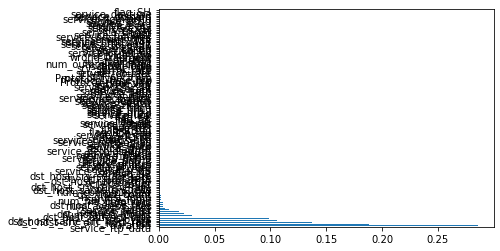

In [68]:
model_R2L = DecisionTreeClassifier(random_state=0)
model_R2L.fit(X_R2L,Y_R2L)
feat_importances_R2L = pd.Series(model_R2L.feature_importances_, index=colNames)
feat_importances_R2L.nlargest(n).plot(kind='barh')
print("Feature importance of R2L : ")
for x in feat_importances_R2L.nlargest(n):
    print(x)
plt.show()

In [69]:
print(feat_importances_R2L)

duration                       0.188707
src_bytes                      0.065980
dst_bytes                      0.004217
land                           0.000000
wrong_fragment                 0.000000
urgent                         0.000000
hot                            0.137141
num_failed_logins              0.022936
logged_in                      0.000510
num_compromised                0.001445
root_shell                     0.000000
su_attempted                   0.000000
num_root                       0.003039
num_file_creations             0.002303
num_shells                     0.000935
num_access_files               0.004024
num_outbound_cmds              0.000000
is_host_login                  0.000000
is_guest_login                 0.001776
count                          0.000850
srv_count                      0.001492
serror_rate                    0.000000
srv_serror_rate                0.000000
rerror_rate                    0.000000
srv_rerror_rate                0.000000


In [70]:
feat_R2L_value = []
R2LIm = []

for y in range(0,122,1):
    feat_R2L_value.append(feat_importances_R2L[y])

R2L_nonzero = [x for x in feat_R2L_value if x != 0]
thresR2L = median(R2L_nonzero)

for j in range(0,122,1):
    if(feat_R2L_value[j] > thresR2L):
        R2LIm.append(j)

n_R2L_feat = len(R2LIm)

In [71]:
param_grid_R2L = {'n_features':[i for i in range(1,n_R2L_feat+1,1)]}

#R2L
cv_res_R2L=[]
for params in ParameterGrid(param_grid_R2L):
    cv_folds = []
        
    dcs = DecisionTreeClassifier(random_state=0)
    rfe_grid = RFE(estimator=dcs, n_features_to_select=params['n_features'], step=1)
    rfe_grid.fit(X_R2L, Y_R2L)
        
    cv_folds.append(rfe_grid.score(X_R2L_test, Y_R2L_test))
    
    cv_res_R2L.append(np.mean(cv_folds))
    print("combination of parameters: " + str(params) + " ended ")

combination of parameters: {'n_features': 1} ended 
combination of parameters: {'n_features': 2} ended 
combination of parameters: {'n_features': 3} ended 
combination of parameters: {'n_features': 4} ended 
combination of parameters: {'n_features': 5} ended 
combination of parameters: {'n_features': 6} ended 
combination of parameters: {'n_features': 7} ended 
combination of parameters: {'n_features': 8} ended 
combination of parameters: {'n_features': 9} ended 
combination of parameters: {'n_features': 10} ended 
combination of parameters: {'n_features': 11} ended 
combination of parameters: {'n_features': 12} ended 
combination of parameters: {'n_features': 13} ended 
combination of parameters: {'n_features': 14} ended 
combination of parameters: {'n_features': 15} ended 


In [72]:
max_rfe_R2L = cv_res_R2L[0]
for m in range(0,len(cv_res_R2L),1):
    if cv_res_R2L[m] > max_rfe_R2L:
        max_rfe_R2L = cv_res_R2L[m]
        ind_max_R2L = f+1
print("Best score RFE : ", max_rfe_R2L)
print("Number of selected features : ", ind_max_R2L)

Best score RFE :  0.8128771038424897
Number of selected features :  14


In [73]:
for x in cv_res_R2L:
    print(x)

0.7708796443315338
0.8115274690377898
0.7425373134328358
0.5877262623054939
0.8128771038424897
0.7629406160685932
0.7774690377897745
0.7569863448713877
0.7606382978723404
0.44418863131152747
0.7846935535090505
0.7846935535090505
0.791838678945697
0.7919974595109559
0.7847729437916799


In [74]:
rfe_R2L = RFE(estimator=est, n_features_to_select=ind_max_R2L, step=1)
#rfe_R2L = RFE(estimator=est, n_features_to_select=14, step=1)
rfe_R2L.fit(X_R2L, Y_R2L)
X_R2L_rfe = rfe_R2L.transform(X_R2L)
true=rfe_R2L.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

print('Features selected for R2L:',rfecolname_R2L)
print()
print(X_R2L_rfe.shape)

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_root', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']

(68338, 14)


In [75]:
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
start7 = time.time()
clf_R2L_rfe = DecisionTreeClassifier(random_state=0)
clf_R2L_rfe.fit(X_R2L_rfe, Y_R2L)
Y_R2L_pred2 = clf_R2L_rfe.predict(X_R2L_test2)
time7 = (time.time()-start7)

In [76]:
cm_R2L_rfe = confusion_matrix(Y_R2L_test, Y_R2L_pred2)
print(pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_R2L_rfe = cm_R2L_rfe[1][1]
FN_R2L_rfe = cm_R2L_rfe[1][0]
FP_R2L_rfe = cm_R2L_rfe[0][1]
TN_R2L_rfe = cm_R2L_rfe[0][0]
acc_R2L_rfe = (TP_R2L_rfe+TN_R2L_rfe)/(TP_R2L_rfe+TN_R2L_rfe+FP_R2L_rfe+FN_R2L_rfe)
sen_R2L_rfe = TP_R2L_rfe/(TP_R2L_rfe+FN_R2L_rfe)
spe_R2L_rfe = TN_R2L_rfe/(TN_R2L_rfe+FP_R2L_rfe)
fal_R2L_rfe = FP_R2L_rfe/(FP_R2L_rfe+TN_R2L_rfe)
print("Accuracy R2L all features : ", acc_R2L_rfe)
print("Sensitivity R2L all features : ", sen_R2L_rfe)
print("Specificity R2L all features :", spe_R2L_rfe)
print("False Alarm rate R2L all features : ", fal_R2L_rfe)
print("Computation time R2L all features : ", time7)

Predicted activity     0    3
Actual activity              
0                   9653   58
3                   2562  323
Accuracy R2L all features :  0.7919974595109559
Sensitivity R2L all features :  0.1119584055459272
Specificity R2L all features : 0.9940273916177531
False Alarm rate R2L all features :  0.005972608382246936
Computation time R2L all features :  0.2449789047241211


### LOCAL OUTLIER FACTOR

In [77]:
print("Dataset shapes before : ")
print(X_R2L_rfe.shape)
print(X_R2L_test2.shape)

model_R2L_lof = LocalOutlierFactor(n_neighbors = 300, contamination='auto')
model_R2L_lof.fit_predict(X_R2L_rfe)
lof_R2L_score = model_R2L_lof.negative_outlier_factor_

R2L_mean = np.mean(lof_R2L_score)
R2L_std = np.std(lof_R2L_score)
print('mean of the dataset is', R2L_mean) 
print('std. deviation is', R2L_std) 

Dataset shapes before : 
(68338, 14)
(12596, 14)
mean of the dataset is -6.558373205241178
std. deviation is 230.257174583631


In [78]:
outlier_zscore_R2L = []
for i in lof_R2L_score:
    z_score_R2L = (i-R2L_mean)/R2L_std
    outlier_zscore_R2L.append(z_score_R2L)
    
outlier_R2L = []
thres_R2L = 3
indexR2L = []
for x in range(0,len(X_R2L_rfe),1):
    if abs(outlier_zscore_R2L[x]) > thres_R2L:
        outlier_R2L.append(outlier_zscore_R2L[x])
    elif abs(outlier_zscore_R2L[x]) < thres_R2L:
        #index non outlier data 
        indexR2L.append(x)

X_R2L_lof = X_R2L_rfe[indexR2L]
Y_R2L_lof = Y_R2L.iloc[indexR2L]

In [79]:
print(len(outlier_R2L))
print(len(indexR2L))

60
68278


In [80]:
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
start9 = time.time()
clf_R2L_lof = DecisionTreeClassifier(random_state=0)
clf_R2L_lof.fit(X_R2L_lof, Y_R2L_lof)
Y_R2L_pred_lof = clf_R2L_lof.predict(X_R2L_test2)
time9 = (time.time()-start9)

In [81]:
cm_R2L_lof = confusion_matrix(Y_R2L_test, Y_R2L_pred_lof)
print(pd.crosstab(Y_R2L_test, Y_R2L_pred_lof, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_R2L_lof = cm_R2L_lof[1][1]
FN_R2L_lof = cm_R2L_lof[1][0]
FP_R2L_lof = cm_R2L_lof[0][1]
TN_R2L_lof = cm_R2L_lof[0][0]
acc_R2L_lof = (TP_R2L_lof+TN_R2L_lof)/(TP_R2L_lof+TN_R2L_lof+FP_R2L_lof+FN_R2L_lof)
sen_R2L_lof = TP_R2L_lof/(TP_R2L_lof+FN_R2L_lof)
spe_R2L_lof = TN_R2L_lof/(TN_R2L_lof+FP_R2L_lof)
fal_R2L_lof = FP_R2L_lof/(FP_R2L_lof+TN_R2L_lof)
print("Accuracy R2L all features : ", acc_R2L_lof)
print("Sensitivity R2L all features : ", sen_R2L_lof)
print("Specificity R2L all features :", spe_R2L_lof)
print("False Alarm rate R2L all features : ", fal_R2L_lof)
print("Computation time R2L all features : ", time9)

Predicted activity     0    3
Actual activity              
0                   9653   58
3                   2562  323
Accuracy R2L all features :  0.7919974595109559
Sensitivity R2L all features :  0.1119584055459272
Specificity R2L all features : 0.9940273916177531
False Alarm rate R2L all features :  0.005972608382246936
Computation time R2L all features :  0.32996320724487305


In [82]:
accuracy = cross_val_score(clf_R2L_lof, X_R2L_lof, Y_R2L_lof, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99922 (+/- 0.00071)


In [83]:
lof_pred = cross_val_predict(clf_R2L_lof, X_R2L_lof, Y_R2L_lof, cv=10)
pd.crosstab(Y_R2L_lof, lof_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,67254,30
3,23,971


### U2R
### Feature Importance

Feature importance of U2R : 
0.19473208481082585
0.1524850374043863
0.09581199602319851
0.09027955321979188
0.08000742447454129
0.07099475865715747
0.0620479985535682
0.05080511958648386
0.03840991339869223
0.03732757816199985
0.02914892239741803
0.016193845776343353
0.01512695058878894
0.015072733376442654
0.015009171223266785
0.014574461198709015
0.009716307465806009
0.005924577083209685
0.005850679764356295
0.0003577404031103968
0.0001231464319032901
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


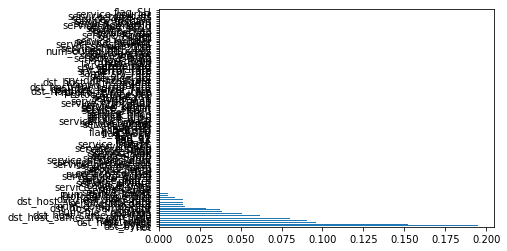

In [84]:
model_U2R = DecisionTreeClassifier(random_state=0)
model_U2R.fit(X_U2R,Y_U2R)
feat_importances_U2R = pd.Series(model_U2R.feature_importances_, index=colNames)
feat_importances_U2R.nlargest(n).plot(kind='barh')
print("Feature importance of U2R : ")
for x in feat_importances_U2R.nlargest(n):
    print(x)
plt.show()

In [85]:
print(feat_importances_U2R)

duration                       0.038410
src_bytes                      0.095812
dst_bytes                      0.152485
land                           0.000000
wrong_fragment                 0.000000
urgent                         0.000000
hot                            0.194732
num_failed_logins              0.000358
logged_in                      0.000000
num_compromised                0.015127
root_shell                     0.080007
su_attempted                   0.000000
num_root                       0.000000
num_file_creations             0.037328
num_shells                     0.070995
num_access_files               0.000000
num_outbound_cmds              0.000000
is_host_login                  0.000000
is_guest_login                 0.000000
count                          0.029149
srv_count                      0.015073
serror_rate                    0.000000
srv_serror_rate                0.000000
rerror_rate                    0.000000
srv_rerror_rate                0.000000


In [86]:
feat_U2R_value = []
U2RIm = []

for y in range(0,122,1):
    feat_U2R_value.append(feat_importances_U2R[y])

U2R_nonzero = [x for x in feat_U2R_value if x != 0]
thresU2R = median(U2R_nonzero)

for j in range(0,122,1):
    if(feat_U2R_value[j] > thresU2R):
        U2RIm.append(j)

n_U2R_feat = len(U2RIm)

In [87]:
param_grid_U2R = {'n_features':[i for i in range(1,n_U2R_feat+1,1)]}

#U2R
cv_res_U2R=[]
for params in ParameterGrid(param_grid_U2R):
    cv_folds = []
        
    dcs = DecisionTreeClassifier(random_state=0)
    rfe_grid = RFE(estimator=dcs, n_features_to_select=params['n_features'], step=1)
    rfe_grid.fit(X_U2R, Y_U2R)
        
    cv_folds.append(rfe_grid.score(X_U2R_test, Y_U2R_test))
    
    cv_res_U2R.append(np.mean(cv_folds))
    print("combination of parameters: " + str(params) + " ended ")

combination of parameters: {'n_features': 1} ended 
combination of parameters: {'n_features': 2} ended 
combination of parameters: {'n_features': 3} ended 
combination of parameters: {'n_features': 4} ended 
combination of parameters: {'n_features': 5} ended 
combination of parameters: {'n_features': 6} ended 
combination of parameters: {'n_features': 7} ended 
combination of parameters: {'n_features': 8} ended 
combination of parameters: {'n_features': 9} ended 
combination of parameters: {'n_features': 10} ended 


In [88]:
max_rfe_U2R = cv_res_U2R[0]
for m in range(0,len(cv_res_U2R),1):
    if cv_res_U2R[m] > max_rfe_U2R:
        max_rfe_U2R = cv_res_U2R[m]
        ind_max_U2R = m+1
print("Best score RFE : ", max_rfe_U2R)
print("Number of selected features : ", ind_max_U2R)

Best score RFE :  0.993659235017386
Number of selected features :  4


In [89]:
for x in cv_res_U2R:
    print(x)

0.9927388013908774
0.9696256903252198
0.9751482920842708
0.993659235017386
0.9870116588259358
0.9766823481284517
0.9764778073225608
0.9928410717938229
0.9932501534056044
0.9843526283493557


In [90]:
rfe_U2R = RFE(estimator=est, n_features_to_select=ind_max_U2R, step=1)
#rfe_U2R = RFE(estimator=est, n_features_to_select=4, step=1)
rfe_U2R.fit(X_U2R, Y_U2R)
X_U2R_rfe = rfe_U2R.transform(X_U2R)
true=rfe_U2R.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

print('Features selected for U2R:',rfecolname_U2R)
print()
print(X_U2R_rfe.shape)

Features selected for U2R: ['src_bytes', 'dst_bytes', 'hot', 'root_shell']

(67395, 4)


In [91]:
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
start8 = time.time()
clf_U2R_rfe = DecisionTreeClassifier(random_state=0)
clf_U2R_rfe.fit(X_U2R_rfe, Y_U2R)
Y_U2R_pred2 = clf_U2R_rfe.predict(X_U2R_test2)
time8 = (time.time()-start8)

In [92]:
cm_U2R_rfe = confusion_matrix(Y_U2R_test, Y_U2R_pred2)
print(pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_U2R_rfe = cm_U2R_rfe[1][1]
FN_U2R_rfe = cm_U2R_rfe[1][0]
FP_U2R_rfe = cm_U2R_rfe[0][1]
TN_U2R_rfe = cm_U2R_rfe[0][0]
acc_U2R_rfe = (TP_U2R_rfe+TN_U2R_rfe)/(TP_U2R_rfe+TN_U2R_rfe+FP_U2R_rfe+FN_U2R_rfe)
sen_U2R_rfe = TP_U2R_rfe/(TP_U2R_rfe+FN_U2R_rfe)
spe_U2R_rfe = TN_U2R_rfe/(TN_U2R_rfe+FP_U2R_rfe)
fal_U2R_rfe = FP_U2R_rfe/(FP_U2R_rfe+TN_U2R_rfe)
print("Accuracy U2R all features : ", acc_U2R_rfe)
print("Sensitivity U2R all features : ", sen_U2R_rfe)
print("Specificity U2R all features :", spe_U2R_rfe)
print("False Alarm rate U2R all features : ", fal_U2R_rfe)
print("Computation time U2R all features : ", time8)

Predicted activity     0   4
Actual activity             
0                   9698  13
4                     49  18
Accuracy U2R all features :  0.993659235017386
Sensitivity U2R all features :  0.26865671641791045
Specificity U2R all features : 0.998661311914324
False Alarm rate U2R all features :  0.0013386880856760374
Computation time U2R all features :  0.08483004570007324


### LOCAL OUTLIER FACTOR

In [93]:
print("Dataset shapes before : ")
print(X_U2R_rfe.shape)
print(X_U2R_test2.shape)

from sklearn.neighbors import LocalOutlierFactor
model_U2R_lof = LocalOutlierFactor(n_neighbors = 300, contamination='auto')
model_U2R_lof.fit_predict(X_U2R_rfe)
lof_U2R_score = model_U2R_lof.negative_outlier_factor_

U2R_mean = np.mean(lof_U2R_score)
U2R_std = np.std(lof_U2R_score)
print('mean of the dataset is', U2R_mean) 
print('std. deviation is', U2R_std) 

Dataset shapes before : 
(67395, 4)
(9778, 4)
mean of the dataset is -322164.03926013
std. deviation is 26549956.29453114


In [94]:
outlier_zscore_U2R = []
for i in lof_U2R_score:
    z_score_U2R = (i-U2R_mean)/U2R_std
    outlier_zscore_U2R.append(z_score_U2R)
    
outlier_U2R = []
thres_U2R = 1
indexU2R = []
for x in range(0,len(X_U2R_rfe),1):
    if abs(outlier_zscore_U2R[x]) > thres_U2R:
        outlier_U2R.append(outlier_zscore_U2R[x])
    elif abs(outlier_zscore_U2R[x]) < thres_U2R:
        #index non outlier data 
        indexU2R.append(x)

X_U2R_lof = X_U2R_rfe[indexU2R]
Y_U2R_lof = Y_U2R.iloc[indexU2R]

In [95]:
print(len(outlier_U2R))
print(len(indexU2R))

13
67382


In [96]:
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
start9 = time.time()
clf_U2R_lof = DecisionTreeClassifier(random_state=0)
clf_U2R_lof.fit(X_U2R_lof, Y_U2R_lof)
Y_U2R_pred_lof = clf_U2R_lof.predict(X_U2R_test2)
time9 = (time.time()-start9)

In [97]:
cm_U2R_lof = confusion_matrix(Y_U2R_test, Y_U2R_pred_lof)
print(pd.crosstab(Y_U2R_test, Y_U2R_pred_lof, rownames=['Actual activity'], colnames=['Predicted activity']))
TP_U2R_lof = cm_U2R_lof[1][1]
FN_U2R_lof = cm_U2R_lof[1][0]
FP_U2R_lof = cm_U2R_lof[0][1]
TN_U2R_lof = cm_U2R_lof[0][0]
acc_U2R_lof = (TP_U2R_lof+TN_U2R_lof)/(TP_U2R_lof+TN_U2R_lof+FP_U2R_lof+FN_U2R_lof)
sen_U2R_lof = TP_U2R_lof/(TP_U2R_lof+FN_U2R_lof)
spe_U2R_lof = TN_U2R_lof/(TN_U2R_lof+FP_U2R_lof)
fal_U2R_lof = FP_U2R_lof/(FP_U2R_lof+TN_U2R_lof)
print("Accuracy U2R all features : ", acc_U2R_lof)
print("Sensitivity U2R all features : ", sen_U2R_lof)
print("Specificity U2R all features :", spe_U2R_lof)
print("False Alarm rate U2R all features : ", fal_U2R_lof)
print("Computation time U2R all features : ", time9)

Predicted activity     0   4
Actual activity             
0                   9698  13
4                     49  18
Accuracy U2R all features :  0.993659235017386
Sensitivity U2R all features :  0.26865671641791045
Specificity U2R all features : 0.998661311914324
False Alarm rate U2R all features :  0.0013386880856760374
Computation time U2R all features :  0.11249732971191406


In [98]:
accuracy = cross_val_score(clf_U2R_lof, X_U2R_lof, Y_U2R_lof, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99938 (+/- 0.00058)


In [99]:
lof_pred = cross_val_predict(clf_U2R_lof, X_U2R_lof, Y_U2R_lof, cv=10)
pd.crosstab(Y_U2R_lof, lof_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,67311,19
4,23,29
